# Import dependencies

In [6]:

import numpy as np
import scipy
from typing import List
import matplotlib as mpl
from dolfinx import fem, mesh
from dataclasses import dataclass
from mpi4py import MPI
from src.solutionOperators import getSourceTerm, solveStateEquation, buildControlFunction, solveAdjointEquation, buildControlFunctionAdjoint
from src.visualization import plot_array, printIterationInfo, timeDependentVariableToGif
from src.ExtremalPoints import ExtremalPoint
from src.HesseMatrix import HesseMatrix
from src.osqp import computeOSQPStep
from src.iterationHelpers import pruneActiveSet, calculateDiscreteGradient,\
    integrateVectorFunction, getIdxMax, calculateFirstDual, calculateSecondDual, showNonStationarity
from src.helpers import buildIterationFunction, computeObjective, linCombFunctionLists, calculateL2InnerProduct
from src.semiSmoothNewtonSolver import computeSSNStep
from src.semiSmoothWalter import computeSSNStepWalter

# Set parameters

In [7]:
@dataclass
class Parameters:
    T = 1
    verbose = True
    useDummy = False
    dt = 0.001
    x1 = (0.5, 0.5)
    x2 = (-0.5, -0.5)
    area = 4
    d = 2
    mollify_const = 0.1
    alpha = 2e-9
    beta = 1e-7
    waveSpeed = 1
    randomFactor = 5
    maxIterations = 50
    pruneThreshold = 0
    maxNewtonSteps = 50
    newton_c = 5
    yd = []
    yd_adjoint = []
    yd_firstDual = None
    yd_secondDual = None
    standardInnerProducts = None
    solver = computeSSNStep
    msh = mesh.create_rectangle(
        comm=MPI.COMM_WORLD,
        points=((-1., -1.), (1., 1.)),
        n=(64, 64),
        cell_type=mesh.CellType.triangle,
    )
    V = fem.functionspace(msh, ("Lagrange", 1))

params = Parameters()

# Setup problem

In [8]:
def setupObservation(s1, s2, params):
	g1 = getSourceTerm(params.x1, params)
	g2 = getSourceTerm(params.x2, params)
	control = buildControlFunction([g1, g2], [s1, s2], params)
	if not params.useDummy:
		K_u = solveStateEquation(control, params)
	else:
		K_u = control
	grid_size = K_u[0].x.array.shape
	raw_matrices = [K_u_t.x.array for K_u_t in K_u]
	norms = [np.linalg.norm(matrix, ord=2) for matrix in raw_matrices]
	scale = params.randomFactor * np.mean(norms) / grid_size[0] * params.area
	np.random.seed(42)
	yd = [fem.Function(params.V) for _ in K_u]
	for idx in range(len(yd)):
		yd[idx].x.array[:] = K_u[idx].x.array + np.random.normal(loc=0.0, scale=scale, size=grid_size)
	params.yd = yd
	params.yd_inner = calculateL2InnerProduct(params.yd,params.yd, params)
	if not params.useDummy:
		params.yd_adjoint = solveAdjointEquation(params.yd, params)
	else:
		params.yd_adjoint = params.yd
	raw_data = np.array([func.x.array for func in params.yd])
	timePoints = np.linspace(0, params.T, num=len(params.yd))
	integrated_raw_data = scipy.integrate.cumulative_simpson(raw_data, x=timePoints, axis=0, initial=0)
	second_integrated_raw_data = scipy.integrate.cumulative_simpson(integrated_raw_data, x=timePoints, axis=0, initial=0)
	params.yd_dual = [fem.Function(params.V) for _ in params.yd]
	params.yd_second_dual = [fem.Function(params.V) for _ in params.yd]
	for idx, (func1, func2) in enumerate(zip(params.yd_dual, params.yd_second_dual)):
		func1.x.array[:] = integrated_raw_data[idx]
		func2.x.array[:] = second_integrated_raw_data[idx]
	#if not params.useDummy:
	#	params.yd_dual_adjoint = solveAdjointEquation(params.yd_dual, params)
	#	params.yd_second_dual_adjoint = solveAdjointEquation(params.yd_second_dual, params)
	#else:
	#	params.yd_dual_adjoint = params.yd_dual
	#	params.yd_second_dual_adjoint = params.yd_second_dual


# Minimization algorithm

In [9]:
def algorithm(active_set_init, weights_init, slope_init, y_shift_init, params: Parameters):
	active_set = []
	active_set[:] = active_set_init
	hesse = HesseMatrix(active_set, params)
 
	if params.verbose:
		print('Objective upper bound: ', computeObjective(np.concatenate((weights_init, slope_init, y_shift_init)), active_set_init, hesse.standard_states, hesse, params))
	weights = np.copy(weights_init)
	slope = np.copy(slope_init)
	y_shift = np.copy(y_shift_init)
	constraintViolation = np.empty(params.maxIterations)
	sizeActiveSet = np.empty(params.maxIterations)
	sizeActiveSet[:] = np.nan
	constraintViolation[:] = np.nan
	weights, slope, y_shift = params.solver(weights, slope, y_shift, active_set, hesse, params)
	if params.verbose:
		print('weights: ', weights, 'slope: ', slope, 'y_shift', y_shift)
		print('Objective: ', computeObjective(np.concatenate((weights, slope, y_shift)), active_set, hesse.standard_states, hesse, params))
	timePoints = np.linspace(0, params.T, num=len(params.yd))

	for k in range(params.maxIterations):
		discreteDf = calculateDiscreteGradient(active_set, weights, slope, y_shift, hesse, params)
		if params.verbose:
			printIterationInfo(k, active_set, weights, slope, y_shift, hesse.matrix)
			showNonStationarity(discreteDf, active_set, params)
		p_k = integrateVectorFunction(discreteDf, params)
		p_k = p_k - np.array([t**2 * p_k[-1,:] / params.T**2 for t in timePoints])
		#p_k_old = calculateFirstDual(active_set, weights, slope, y_shift, hesse, params)
		#P_k = -integrateVectorFunction(p_k, params)
		#P_k_old = calculateSecondDual(active_set, weights, slope, y_shift, hesse, params)
		P_k = integrateVectorFunction(discreteDf * timePoints[:, np.newaxis], params) - p_k * timePoints[:, np.newaxis]
		P_k = P_k - np.array([t**2 * P_k[-1,:] / params.T**2 for t in timePoints])
		if params.verbose:
			u_k = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)
			print('Boundary values of duals: ', p_k[-1,:]/params.alpha, P_k[-1,:]/params.beta)
			_, (ax1, ax2, ax3, ax4) = mpl.pyplot.subplots(1, 4, figsize=(20, 5))
			plot_array(discreteDf, params.T, label='grad', ax=ax1)
			ax2.plot(timePoints, p_k/params.alpha, linestyle='-', color='b', label='|p_k|/alpha')
			ax3.plot(timePoints, P_k/params.beta, linestyle='-', color='b', label='|P_k|/beta')
			ax2.grid(True), ax3.grid(True)
			plot_array(np.array([u_k(t) for t in timePoints]), params.T, label='iteration function', ax=ax4)
			mpl.pyplot.show()

		idx_S = getIdxMax(p_k, active_set, type=0)
		idx_K = getIdxMax(P_k, active_set, type=1)
		norm_p_max = np.linalg.norm(p_k[idx_S])
		norm_P_max = np.linalg.norm(P_k[idx_K])
		if params.verbose:
			print('|p_max|/alpha: ', norm_p_max / params.alpha,  ', |P_max|/beta: ', norm_P_max / params.beta)
		constraintViolation[k] = max(norm_p_max / params.alpha, norm_P_max / params.beta) - 1
		sizeActiveSet[k] = len(active_set)
		if (max(norm_p_max / params.alpha, norm_P_max / params.beta) <= 1):
			break
		if norm_p_max / params.alpha >= norm_P_max / params.beta:
			new_sigma = p_k[idx_S] / norm_p_max
			new_x_0 = idx_S * params.dt
			new_type = 0
		else:
			new_sigma = P_k[idx_K] / norm_P_max
			new_x_0 = idx_K * params.dt
			new_type = 1
		active_set.append(ExtremalPoint(new_sigma, new_x_0, type=new_type, params=params))
		if params.verbose:
			print('x_S: ', idx_S * params.dt, 'x_K: ', idx_K * params.dt, '\nNew point: sigma=', active_set[-1].sigma, 'x_0 =', active_set[-1].x_0, ', type =', active_set[-1].type)
		hesse.extendMatrix(active_set[-1])
		weights, slope, y_shift = params.solver(np.concatenate((weights, np.array([1.]))), slope, y_shift, active_set, hesse, params)
		if params.verbose:
			print('weights: ', weights, 'slope: ', slope, 'y_shift', y_shift)
		# check double time in idx_double
		# if (double index))
		# weight_comb_new = weights[idx_double] * active_set[idx_double].sigma + weights[-1] * active_set[-1].sigma
		# weight_new = np.linalg.norm(weight_comb_new)
		# if (weight_new > 0)
		# active_set.append(ExtremalPoint(weight_comb_new/weight_new, new_x_0, type=new_type, params=params))
		active_set, weights = pruneActiveSet(active_set, weights, params.pruneThreshold)
		hesse.pruneMatrix(active_set, weights)
		#if params.verbose:
		#	print('Objective: ', computeObjective(np.concatenate((weights, slope, y_shift)), active_set, hesse.standard_states, hesse, params))

	u_k = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)
	fig, (ax1, ax2, ax3, ax4) = mpl.pyplot.subplots(1, 4, figsize=(20, 5))
	plot_array(discreteDf, params.T, label='grad', ax=ax1)
	ax2.plot(timePoints, np.linalg.norm(p_k, axis=1)/params.alpha,  linestyle='-', color='b', label='|p_k|/alpha')
	ax3.plot(timePoints, np.linalg.norm(P_k, axis=1)/params.beta, linestyle='-', color='b', label='|P_k|/beta')
	plot_array(np.array([u_k(t) for t in timePoints]), params.T, label='iteration function', ax=ax4)
	mpl.pyplot.show()
	printIterationInfo(k, active_set, weights, slope, y_shift, hesse.matrix)
	showNonStationarity(discreteDf, active_set, params)
	return active_set, weights, slope, y_shift, constraintViolation, sizeActiveSet


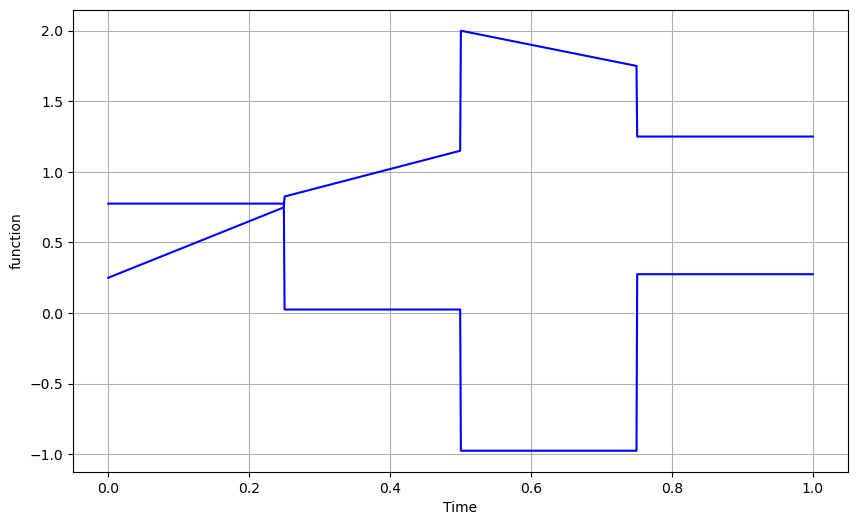

Test for alpha= 7e-09 , beta= 1e-09
Objective upper bound:  3.543735523179392e-06
weights:  [] slope:  [ 2.11440958 -2.38147475] y_shift [0.2653072  0.94479942]
Objective:  1.5554006123862695e-07
0 : Active set:
slope:  [ 2.11440958 -2.38147475] y_shift [0.2653072  0.94479942]
0 : Hesse condition: 60.44887388762816
First conditions:  [ 1.26646255e-10 -2.60788713e-10  3.40998039e-12 -3.33736187e-10]  (should be close to 0)
Second conditions:  []  (should be greater or equal than 0)
Boundary values of duals:  [0. 0.] [0. 0.]


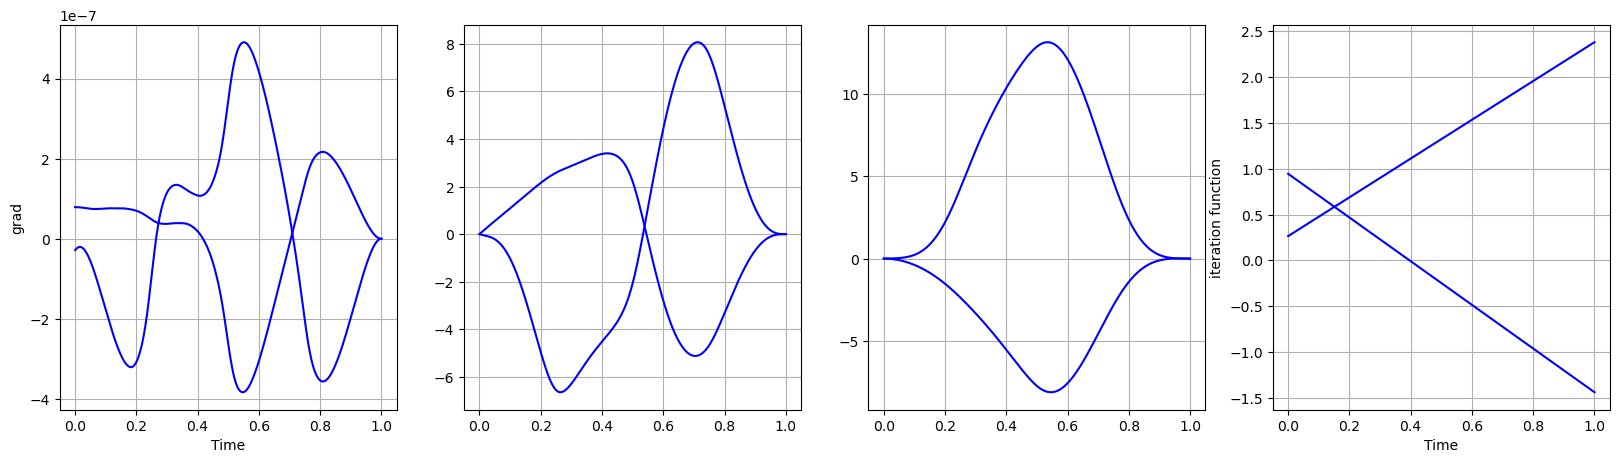

|p_max|/alpha:  9.556094613327696 , |P_max|/beta:  15.403604472299675
x_S:  0.71 x_K:  0.538 
New point: sigma= [-0.52508702  0.85104855] x_0 = 0.538 , type = 1
weights:  [5.1218715] slope:  [ 2.73711799 -3.38394361] y_shift [0.12970144 1.16150908]
1 : Active set:
	 0 sigma= [-0.52508702  0.85104855] ,	x_0 = 0.538 ,	type = 1 	weight: 5.121871503102572 	id: 140707719014176
slope:  [ 2.73711799 -3.38394361] y_shift [0.12970144 1.16150908]
1 : Hesse condition: 1801.7854048768697
First conditions:  [-2.72613018e-11 -9.08045918e-12 -9.66886897e-11 -1.63504612e-10]  (should be close to 0)
Second conditions:  [1.]  (should be greater or equal than 0)
Boundary values of duals:  [0. 0.] [0. 0.]


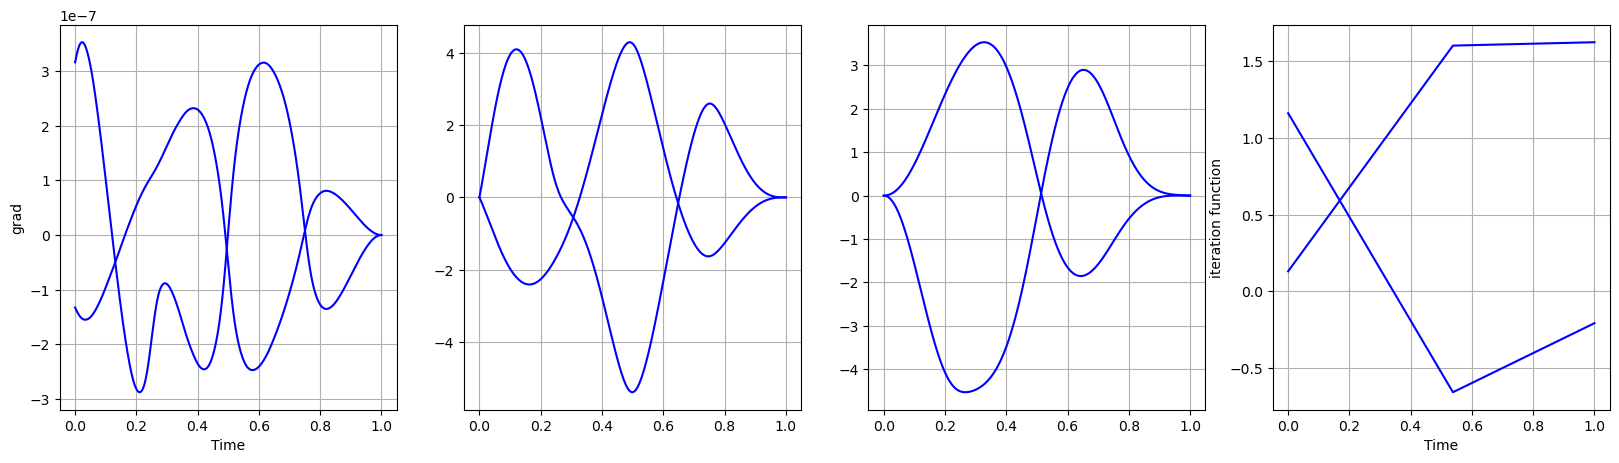

|p_max|/alpha:  6.871135185777111 , |P_max|/beta:  5.652293467764053
x_S:  0.496 x_K:  0.303 
New point: sigma= [ 0.62223575 -0.78282991] x_0 = 0.496 , type = 0
weights:  [6.8008199  0.96689798] slope:  [ 1.9677972  -2.48969218] y_shift [0.26203424 1.01102688]


KeyboardInterrupt: 

In [10]:
def testRegularizationParameters(alpha, beta, params, originalSignal):
    params.alpha = alpha
    params.beta = beta
    print('Test for alpha=', alpha, ', beta=', beta)
    active_set = []
    weights = np.ones(len(active_set))
    slope = np.ones(params.d)
    y_shift = np.ones(params.d)    
    active_set, weights, slope, y_shift, constraintViolation, sizeActiveSet = algorithm(active_set, weights, slope, y_shift, params)
    printIterationInfo(0, active_set, weights, slope, y_shift, np.identity(1))
    timePoints = np.linspace(0, params.T, num=int(params.T/params.dt))
    u_fin = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)
    reconstruction = np.array([u_fin(t) for t in timePoints])
    fig, (ax1, ax2) = mpl.pyplot.subplots(1, 2, figsize=(10, 5))
    
    ax1.plot(timePoints, originalSignal[:, 0], label='u(t)')
    ax1.plot(timePoints, reconstruction[:, 0], label='$\tilde{u}(t)$')
    ax2.plot(timePoints, originalSignal[:, 1], label='u(t)')
    ax2.plot(timePoints, reconstruction[:, 1], label='$\tilde{u}(t)$')
    mpl.pyplot.show()
    fig, (ax3, ax4) = mpl.pyplot.subplots(1, 2, figsize=(10, 5))
    plot_array(constraintViolation, T=len(constraintViolation), label='Constraint violation', ax=ax3)
    ax3.set_yscale('log')
    plot_array(sizeActiveSet, T=len(sizeActiveSet), label='Size active set', ax=ax4)
    mpl.pyplot.show()

params.maxIterations = 40
params.newton_c = 1
params.maxNewtonSteps = 50
params.pruneThreshold = 1e-5
params.verbose = True
params.mollify_const = 0.01
params.solver = computeSSNStepWalter

s1 = lambda t: (2*t+0.25 if t < 0.25 else(1.3*t + 0.5 if t < 0.5 else (-t+2.5 if t < 0.75 else 1.25)))
#s1 = lambda t : (0.05 if t <= 0.25 else (0.65 if t <= 0.5 else (0.15 if t <= 0.75 else 0.35)))
#s1 = lambda t : (0.05*t if t <= 0.25 else (0.90*t + 1 if t <= 0.5 else -2 - 0.95*t if t <= 0.75 else 0.3)) #/ params.alpha
s2 = lambda t : (0.775 if t <= 0.25 else (0.025 if t <= 0.5 else (-0.975 if t <= 0.75 else 0.275)))
setupObservation(s1, s2, params)

g1 = getSourceTerm(params.x1, params)
g2 = getSourceTerm(params.x2, params)
#gradient_test = buildControlFunctionAdjoint([g1, g2], solveAdjointEquation(params.yd, params), params)
timePoints = np.linspace(0, params.T, num=int(params.T/params.dt))
array = np.ndarray((int(params.T/params.dt), 2))
array[:, 0] = np.array([s1(t) for t in timePoints])
array[:, 1] = np.array([s2(t) for t in timePoints])
plot_array(array, params.T)

testRegularizationParameters(7e-9, 1e-9, params, array)
#testRegularizationParameters(1e-8, 1e-6, params, array)
#testRegularizationParameters(5e-8, 1e-8, params, array)